# Grundy Numbers
### Experimental Math Final Project
### Author: Garrett Van Beek
### Professor Diego Villamizar
### May 8, 2020

## I. Introduction
For my project, I chose to study combinatorial game theory. Specifically, I looked at Grundy Numbers (a.k.a. Nimbers) and the Grundy-Sprague Theorem.

### What is Combinatorial Game Theory
The simplest definition of game theory is the study of "games". It is a field that seeks to find the best strategy within "games", which are really just interactions between two different parties, in which a utility is defined. There are many different types of games. Combinatorial games are games with the following properties:
* Perfect Infomation: The entire state space is known.
* Deterministic: players action have a deterministic effect on the world (100% chance of happening).
* Zero-Sum: players can either win or lose, but not both. Draws are also possible
* Terminating: a game may not go on forever

### What is Nim?
Nim is a game that falls into the Category of Combinatorial Games. The rules of nim are:
* The game is initialized with an arbitrary number of piles. Each pile contains an arbitrary number of stones.
* Players take turns removing stones from piles.
* A player may only take from one pile per turn.
* A player must take 1-3 stone(s) every turn.
* The player who takes the last stone(s) wins.




Nim is used used in the exploration of game theory because it has a very interesting property: Given the start state of any game, and the player who moves first, it is possible to determine the winner if both parties play optimally. This is incredibly significant because it can be abstracted and applied to other combinatorial games. In order to determine the winner of the game, and optimal play, one must first calculate the Grundy Number (a.k.a. Nimber) of that state.



### How do we calculate Nimbers?
Grundy numbers are calculated recursively. The base case is the losing state. It occurs when there are no stones left on the board for a player to draw. In this case, the player loses. All other states are defined recursively as the _minimal excludant of the set of Grundy number of successor states_.

Once we have the Grundy Numbers of a game, we may, without playing the game, determine the winner of the game. This is what is known as the Grundy Sprague Theorem

### The Grundy Sprague Theorem
Suppose there is a composite game (made up of sub games), with two players A (moving first) or B (moving second). When both player play optimally, we may determine the winner as follows.

* If the cumulative XOR the Grundy Numbers of the sub-games is 0, player A will lose.
* Player A will wins otherwise.

This theorem can be extended to other deterministic, impartial games of perfect information (tic-tac-toe for example), once we calculate the nimbers for the game.

## II. Exploration
For the exploratory phase of my assignement. I chose to encode and analyze the game of nim. I created multiple agents that play the game of NIM. You may run these different agents, using the text-based user interface I created. `cd` into the folder of my project then run `python3 play_nim.py`. Note: this interface is not a best programming practice, but I chose it for ease of use. The best practice is to pass in the options as arguements to the function call.

#### Random Agent
It's important to start small. In order to test everything, I first made a random agent, that returns a random action. Play against it with option `r`.

In [ ]:
class random_player(nim_player):
    def get_move(self, game_state):
        take = -1
        pile = random.randrange(0,len(game_state), 1)
        #randomly select a number of stones to remove
        take = random.choice([1,2,3])

        # return an action, precisely the pile, take pair
        print("random player removed " + str(take) + " stones from pile " +str(pile))
        return (pile, take)

#### Human Agent
This is an agent that asks the use to input the desired move. This is for testing and playing nim. You may play nim with your friends with option `h`.

In [ ]:
class human_player(nim_player):
    def __init__(self):
        print("Enter player name")
        self.name = input()
    #print a visual of the nim game
    def vis_game(self, game_state):
        print("\nPILE # |   STONES")
        for i in range(0, len(game_state)):
            print("  " + str(i) + "    | ", end="")

            for j in range(game_state[i]):
                print("0 ", end="")
            print("")

        print("AS LIST ", game_state)
        print("")
        
    '''Ask the human player to input a move'''
    def get_move(self, game_state):
        #print(game_state)
        print("PLAYER " + self.name)
        self.vis_game(game_state)
        while True:
            pile = int(input("Enter a pile to take from: "))
            take = int(input("Enter the amount of stones to take (between 1 and 3): "))
            # input validation
            if (pile < len(game_state)) and (pile >= 0) and (take > 0) and (take <= 3):
                break
            print("Invalid input, try again")

        return (pile, take)

#### Binary XOR Agent
It follows from the Grundy-Sprague Theorem that the an optimal action is one that places the opponent in a losing state. I encoded a Binary XOR Evaluation agent that determines an optimal action with the following pseudocode:
_Calculate the cumulative binary XOR of the current game state. If it is zero, return an arbitrary action because the game is lost._
_Otherwise, calculate the cumulative binary XOR of the successor state of every action. If a successor states cumulative XOR is zero, we have found a winning action. Return it.
If no successor state with a cumulative binary XOR of zero is found. Return an arbitrary action. (optimal play is unkown)_

This agent will play optimally except in edge cases where the cumulative XOR is non-zero and there are no succesor states such that the cumulative XOR is zero.

In [ ]:
'''calculate the nim_sum (cummulative XOR) for a given state'''
def nim_sum(game_state):
    acc_sum = 0
    for i in game_state:
        acc_sum = acc_sum ^ i
    return acc_sum

'''search for an action that makes the nim_sum zero'''
def binary_policy(game_state):
    if nim_sum(game_state) == 0:
        print("BINARY: I can't win if you play optimally :P")
        return (0,1)
    else:
        for i in range(0, len(game_state)):
            for j in range(1,4):
                action = (i,j)
                temp_state = game_state.copy()
                temp_state[i] -= j
                if nim_sum(temp_state) == 0:
                    print("BINARY: There is nothing you can do to beat me LOSER!")
                    return action
        print("BINARY: I can't find an optimal move, its anybody's game!")
        return (0,1)

''' Player that follows the binary policy'''
class binary_player(nim_player):
    def get_move(self, game_state):
        return binary_policy(game_state)

Even though this agent plays with an optimal policy deduced from the Grundy-Sprague Theorem. This policy is not complete, in other words, the agent does not always play optimally. In order for a complete, optimal strategy, we must evaluate each state using Grundy numbers.

#### Dynamic Agent
The last agent I wrote used a dynamic programming algorithm to calculate the optimal move for any given game state of nim. It calculated the nimbers for each state recursively. Then it choses the optimal action, which was the action that minimized the minimal excludant of successor states. You may play against this agent with option `d`.

In [ ]:
'''Player that dynaimcally evalutes game states of nim'''
class dynamic_player(nim_player):
    cache = {}
    def get_move(self, game_state):
        eval = self.dynamic_eval(game_state)
        return eval[0]
    def __init__(self, cache_file):
        # open the cache file to read
        f = open(cache_file, "r")
        # write every line in the cache file to the dictionary
        for line in f:
            key_val_pair = line.split(":")
            self.cache[key_val_pair[0]] = eval(key_val_pair[1])
    '''Save cache to a text file'''
    def save_cache(self, cache_file):
        # delete old cache file
        if os.path.exists(cache_file):
            os.remove(cache_file)
        f = open(cache_file, "a")
        # write each entry of the dictionary to the cache_file
        for i in self.cache:
            line = ( i + ":" + str(self.cache[i]) +"\n" )
            f.write(line)
        f.close()

    '''recursive, dynamic programming algorithm that calculates the optimal action in a game of NIM'''
    def dynamic_eval(self, game_state):
        # Check cache for game state
        #### if gamestate in cache, return evaluation
        if str(game_state) in self.cache:
            # return evaluation
            return self.cache[str(game_state)]
        #### gamestate not in cache, evaluate it recursively
        else:
            ## recursively call dynamic_eval to evaluate legal actions,
            action_to_return = ( (0,0), 99999999)
            succ_nimbers = []

            ## calculate the nimber = minimal excludant of all nimbers of successor states.
            #iterate over pile indices
            for i in range(len(game_state)):
                # iterate over number of stones to take
                for j in range(1,4):
                    action = (i, j)
                    # generate transition state
                    next_state = nim_game.do_move(game_state, action)
                    # evaluate transition state
                    next_state_eval = self.dynamic_eval(next_state)

                    #add the nimber to the current list of succ_nimbers
                    succ_nimbers.append(next_state_eval[1])

                    #return the action that minimizes the nimber
                    if next_state_eval[1] == 0:
                        action_to_return = (action, 0)
                    else:
                        # return action that minimizes succ state nimbers
                        if action_to_return[1] >= next_state_eval[1]:
                            action_to_return = (action, next_state_eval[1])
        #pair the best action and the mex nimber
        action_tuple = (action_to_return[0], mex(succ_nimbers))
        
        # add to cache
        self.cache[str(game_state)] = action_tuple
        return action_tuple


#### Mining Solutions
I wanted to gather data on Nimbers. The option `m` of the text-interface sets my dynamic agent to play against itself. Then it saves the cache generated to a text file `mine_cache.txt`. You many run this option if you wish to mine solutions on your own computer. Warning: it will run indefinitley, use `ctrl+c` to stop mining solutions. In under thirty minutes, my alorithm calculated the nimbers (and thus optimal play) for over 12 million game states. That goes to show the power of dynamic programming! Here is a sample of the cache file.

#### Symmetry Breaking
The problem space of Nim is considerably large. For every state with n piles, there are approximately, 3n actions. We must check every action at every state. Yielding an uppder bound runtime of `t!*n!*3n` search space. `t` is the number of game states. However, many of the actions are symmetric, meaning that the optimal solution will be the same for both. I employed symmetry breaking to remove these symmetric states. Every Nim state is represented as a list of numbers. I imposed an order on this list of numbers to remove symmetric states. For example, by ordering the list, I reduced the states
`[1,2,3],[2,1,3],[1,3,2],[3,2,1],[3,1,2],[2,3,1] ---> [1,2,3]`

This reduced the search space from `t!*n!*3n` to `t!*3n`. An incredibly significant improvement.

## III. Visualization and Analysis
Next I wanted to observe some of the properties of nimbers. So I used the cache file that I mined with dynamic programming. I loaded and analyzed the data using Pandas.

In [6]:
import pandas as pd

my_df = pd.read_csv("mine_cache.txt1", sep=":")

my_df

FileNotFoundError: [Errno 2] File b'mine_cache.txt1' does not exist: b'mine_cache.txt1'

I had a lot more data points than my laptop could handle. I chose to only observe the first one million entries.

In [7]:
my_df = my_df.drop(range(1000000, 12309522))

KeyError: '[1000000 1000001 1000002 ... 12309519 12309520 12309521] not found in axis'

#### Data Cleaning
I had to clean my data before I could analyze it. The below code makes sure every data point contains the correct data types.

In [ ]:
# remove parenthesis
my_df['(ACTION,NIMBER)'] = my_df['(ACTION,NIMBER)'].replace('([()])', "", regex=True)
# convert gamestat to list
my_df["GAMESTATE"] = my_df["GAMESTATE"].apply(lambda x: x[1:-1].split(","))

#split action, nimber tuple
my_df["action"] = my_df['(ACTION,NIMBER)'].apply(lambda x: x.split(",")[0:2])
my_df["nimber"] = my_df['(ACTION,NIMBER)'].apply(lambda x: x.split(",")[2])

# drop the old action nimber pair
my_df = my_df.drop('(ACTION,NIMBER)', axis=1)

# convert nimber data type to integer
my_df = my_df.astype({"nimber": "int64"})

In [ ]:
my_df.dtypes

#### Analysis
Let's see how frequently we see each nimber.

In [ ]:
my_df["nimber"].value_counts()

From this we can see that each nimber makes up about 25% of all game states.

In [ ]:
pie_chart = my_df["nimber"].value_counts().plot.pie()
pie_chart

From the point of view of the first player, 25% of all Nim games are lost from the beginning. The other 75% are winning states. By observing this, we can deduce the optimal choice when a player is asked whether to move first or second. __A player should always decide to move first if they do not know the game state.__

Let's also check how complete our binary XOR evaluation policy was. I did this by calculating the percentage of losing games (nimber = 0) whose cumulative binary xor of the gamestate was also 0.

In [ ]:
#subset of only losing games
losing_states = my_df[my_df['nimber'] == 0]

# function calculating cumulative binary XOR of a list of integers
def binary_xor(gamestate):
    acc_sum = 0
    for i in gamestate:
        try:
            i = int(i)
            acc_sum = acc_sum ^ i
        except:
            continue
    return acc_sum

# create a new column showing the binary XOR of each losing state
losing_states["XOR"] = losing_states["GAMESTATE"].apply(lambda x: binary_xor(x))

losing_states




In [8]:
binary_xor([3, 3, 5, 7, 8, 8, 8, 9, 10, 10, 11] + [3, 3, 5, 7, 8, 8, 8, 9, 11, 11, 11])

0

Now lets calculate how many of these losing states can be found by my binary xor evaluation policy.

In [46]:
losing_states["XOR"].value_counts()

4     63475
8     62959
0     62352
12    61404
Name: XOR, dtype: int64

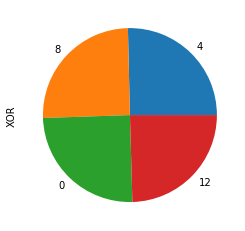

In [47]:
losing_states["XOR"].value_counts().plot.pie()

The binary evaluation policy was able to evaluate 25% of total losing states. Even more interestingly, the binary XOR of a losing states is always a multiple of 4. To write an optimal complete policy, we need to evaluate all states whose cumulative binary XOR is a multiple of 4 as losing states. By the Grundy-Sprague theorem, this policy is complete and optimal.

## IV. Conclusion
We can use nimbers to develop and evaluate policies for the game of nim. Earlier we found that the optimal policy was to chose an action with a successor state such that the _cumulative XOR of the number of stones in every pile is a multiple of 4_. Nim is also interesting because it can be extended to any impartial, two-person, deterministic, zero-sum, game. We could use the same strategies to evaluate nim in games like Tic-Tac-Toe and Mancala. Furthermore, we may apply game theory real-life situations instead of games.

Suppose two competing stores are filling their stocks with products of a limited supply. The stores can only purchase a finite number of products at once. Neither store wants to run out of stock before their opponent. That is, if they run out of stock they loose.

This situation can be defined as a game in the same class as Nim. We could calculate the nimbers for the game and deduce the optimal strategy for each shop.

Thank you for reading!

__THE END__

## Sources
https://www.geeksforgeeks.org/introduction-to-combinatorial-game-theory/ <br>
https://www.geeksforgeeks.org/combinatorial-game-theory-set-2-game-nim/?ref=lbp <br>
https://www.geeksforgeeks.org/combinatorial-game-theory-set-3-grundy-numbersnimbers-and-mex/?ref=lbp <br>
https://www.geeksforgeeks.org/combinatorial-game-theory-set-4-sprague-grundy-theorem/?ref=lbp <br>

http://library.msri.org/books/Book29/files/unsolved.pdf <br>
